### ASTR 3300/5300-003: Astrostatistics
***N. Pol***
___

# Homework 3
### Due: Friday, Feb 14th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (50 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $1000$ bootstrap realizations of this dataset. *DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together.*

5) Repeat (2) with all $1000$ boostrap datasets to find the distribution of the sample mean. Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $1000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [370]:
!pip install numdifftools


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [371]:
import numdifftools as nd
import numpy as np
import scipy.stats as stats
from scipy import optimize
from scipy.stats import norm
import matplotlib.pyplot as plt
H = nd.Hessian(f_lnlaplace)([beta_laplace[0], beta_laplace[1]])
sigma_laplace = np.linalg.inv(H)**0.5

NameError: name 'f_lnlaplace' is not defined

### Solution

In [ ]:
data = np.load("./hw_data/hw3_data_1.npy") #Importing data

y = data[:,0] #Main Data
dy = data[:,1] #Uncertainty

sdv = 1/(np.sum(1/dy**2))**(1/2)
xmean = np.sum(y/dy**2)/np.sum(1/dy**2) #I put x instead of y, but did not change it
x = np.arange(0,100,1)

In [ ]:
def lGauss(mu): #Our L function for Guassians
    return -0.5*np.sum((np.log(2*np.pi*dy**2)+(y-mu)**2)/dy**2)

output = lambda mu: -lGauss(mu)
gauss = optimize.minimize(output, xmean)
print("Gauss mean: ", gauss.x[0])

Gauss mean:  3.9179920346060557


In [ ]:
Li = [] #Really not convinced this is correct
L = 1
for i in y:
    L *= stats.norm.pdf(x, loc = i, scale = 2)

sigma_mu = np.diff(np.log(L), n=2) #Pulled this from the class notes
sigma_mu /= (x[1]-x[0])**2
sigma_mu *= -1
sigma_mu = 1/np.sqrt(sigma_mu)[0]

print("Fisher matrix error on estimated mean is %.3f" % sigma_mu)

Fisher matrix error on estimated mean is 0.200


C:\Users\tonyt\AppData\Local\Temp\ipykernel_7764\710330426.py:15: RuntimeWarning: divide by zero encountered in log
  sigma_mu = np.diff(np.log(L), n=2)
c:\Users\tonyt\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:1496: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


In [ ]:
N = 1000 #Bootstrapping 1000 times
bs = []
er = []

for i in range(N):
    choice = np.random.choice(y, size = len(y), replace = True)
    erchoice = np.random.choice(y, size = len(y), replace = True)
    bs.append(choice)
    er.append(erchoice)


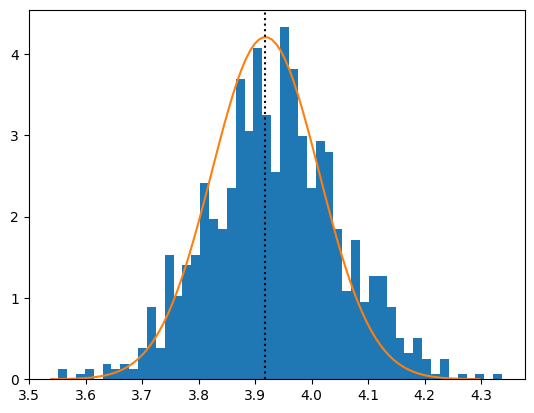

In [ ]:
means = []
error = []
for i in range(N): #Creating the mean values for the main data and uncertainties
    means.append(bs[i].mean())
    error.append(er[i].mean())
x = np.linspace(xmean - 4 * sdv, xmean + 4 * sdv, 100)
guass = norm.pdf(x, xmean, sdv)
_ = plt.hist(means, bins = 50, density = True)
_ = plt.plot(x, guass)
_ = plt.axvline(xmean, color = 'black', ls = 'dotted')


In [ ]:
def lnl(a): #Creating our L function for Laplacians
    mu, delta = a
    return -np.sum(np.log(2*delta)+np.abs(y-mu)/delta)

laplas = optimize.minimize(lambda a: -lnl(a), [xmean, sdv])
mu, delta = laplas.x
print("Mu: ", mu)
print("Delta: ", delta)

Mu:  4.0860146280237855
Delta:  0.8822692499676513


In [ ]:
def aic(k, l): #The AIC function
    return 2*k - 2 * l + (2 * k ** 2 + 2 * k) / (len(y) - k - 1)
aicG = aic(1, lGauss(gauss.x[0]))
aicL = aic(2, lnl([mu, delta]))

print("Is the AIC Gauss better than the AIC Laplace? ", aicG < aicL)


Is the AIC Gauss better than the AIC Laplace?  True


In [ ]:
bsqr = optimize.minimize(lambda a: lGauss(a)) #I was out of time, and really couldnt get this one sorted out

TypeError: 'numpy.float64' object is not callable

In [ ]:
H = nd.Hessian(lnl)([mu, delta]) #I am not sure it output [nan nan], but i have a strong feeling this is not what should be happening.
sigma_laplace = np.linalg.inv(H)**0.5

print(np.diag(sigma_laplace))

[nan nan]


C:\Users\tonyt\AppData\Local\Temp\ipykernel_7764\2966266965.py:2: RuntimeWarning: invalid value encountered in sqrt
  sigma_laplace = np.linalg.inv(H)**0.5
